# measuring the relaxation time with the idling gate
In order to demonstrate the simulation of decoherence noise, we build an example that simulates a Ramsey experiment as a quantum circuit run on a noisy `Processor`.
The Ramsey experiment consists of a qubit that is initialized in the excited state, undergoes a $\pi/2$ rotation around the $x$ axis, idles for a time $t$, and is finally measured after another $\pi/2$ rotation:

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


T2: 20.0
Fitted T2: 20.05671956410088


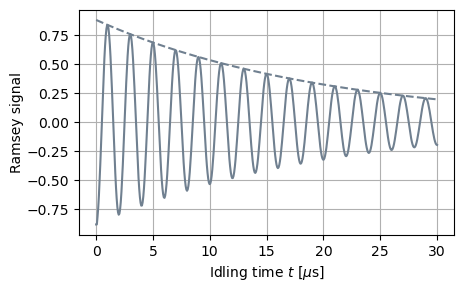

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from qutip import basis, sigmax, sigmaz
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import LinearSpinChain
import qutip_qip
from qutip.ipynbtools import version_table

pi = np.pi
num_samples = 500
amp = 0.1
f = 0.5
t2 = 10 / f

# Define a processor.
proc = LinearSpinChain(num_qubits=1, sx=amp / 2, t2=t2)
ham_idle = 2 * pi * sigmaz() / 2 * f
resonant_sx = 2 * pi * sigmax() - ham_idle / (amp / 2)
proc.add_drift(ham_idle, targets=0)
proc.add_control(resonant_sx, targets=0, label="sx0")


# Define a Ramsey experiment.
def ramsey(t, proc):
    qc = QubitCircuit(1)
    qc.add_gate("RX", 0, arg_value=pi / 2)
    qc.add_gate("IDLE", 0, arg_value=t)
    qc.add_gate("RX", 0, arg_value=pi / 2)
    proc.load_circuit(qc)
    result = proc.run_state(init_state=basis(2, 0), e_ops=sigmaz())
    return result.expect[0][-1]


idle_tlist = np.linspace(0.0, 30.0, num_samples)
measurements = np.asarray([ramsey(t, proc) for t in idle_tlist])

rx_gate_time = 1 / 4 / amp  # pi/2
total_time = 2 * rx_gate_time + idle_tlist[-1]
tlist = np.linspace(0.0, total_time, num_samples)

peak_ind = scipy.signal.find_peaks(measurements)[0]


def decay_func(t, t2, f0):
    return f0 * np.exp(-1.0 / t2 * t)


(t2_fit, f0_fit), _ = scipy.optimize.curve_fit(
    decay_func, idle_tlist[peak_ind], measurements[peak_ind]
)
print("T2:", t2)
print("Fitted T2:", t2_fit)

fig, ax = plt.subplots(figsize=(5, 3), dpi=100)
ax.plot(idle_tlist[:], measurements[:], "-", label="Simulation",
        color="slategray")
ax.plot(
    idle_tlist,
    decay_func(idle_tlist, t2_fit, f0_fit),
    "--",
    label="Theory",
    color="slategray",
)
ax.set_xlabel(r"Idling time $t$ [$\mu$s]")
ax.set_ylabel("Ramsey signal", labelpad=2)
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]))
ax.set_position([0.18, 0.2, 0.75, 0.75])
ax.grid()

In the above block, we use the linear spin chain processor just for its compiler and do not use any of its default Hamiltonians.
Instead, we define an always-on drift Hamiltonian $\sigma^z$ with frequency $f=0.5$MHz, an on-resonant $\sigma^x$ drive with an amplitude of $0.1/2$MHz and the coherence time $T_2=10/f$.
For different idling time $t$, we record the expectation value with respect to the observable $\sigma^z$ as the solid curve.
As expected, the envelope follows an exponential decay characterized by $T_2$ (dashed curve).
Notice that, because $\pi/2$-pulses are simulated as a physical process, the fitted decay does not start from 1.
This demonstrates a way to include state preparation error into the simulation.

In [2]:
print("qutip-qip version:", qutip_qip.version.version)
version_table()

qutip-qip version: 0.5.0.dev0+81a92b9


Software,Version
QuTiP,5.3.0.dev0+6e4b53d
Numpy,2.3.5
SciPy,1.16.3
matplotlib,3.10.8
Number of CPUs,4
BLAS Info,blas
IPython,9.8.0
Python,"3.12.0 | packaged by conda-forge | (main, Oct 3 2023, 08:43:22) [GCC 12.3.0]"
OS,posix [linux]
Cython,3.2.2
